# Finding needles in a compressed haystacks 
-- Mohit Kumar Meena (213070021)

# Data Exploration

In [ ]:
import numpy as np
import scipy.signal as sig
import pywt
# from pywt import 
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
# Loading the original broadatz data 
path = "/content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/D1.gif"
im = Image.open(path)

# To iterate through the entire gif
try:
    while 1:
        im.seek(im.tell()+1)
        # do something to im
except EOFError:
    pass # end of sequence

widths = np.arange(1,639)

num_im = np.asarray(im, dtype='int64')
print(np.shape(num_im))

(640, 640)


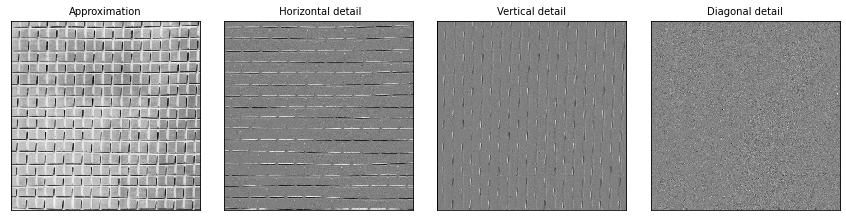

In [ ]:
# Exploring a test image through wavelet decomposition
coeffs2 = pywt.dwt2(num_im, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
# Collecting files for K-means clustering of the data
import glob
path_list = sorted(glob.glob("/content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/*"), key= lambda x : int(x.split(".gif")[0].split("/D")[1]))

original = []
approximation = []
horizontal = []
vertical = []
diagonal = []

for i in range(len(path_list)):
  print("collecting for file : ", path_list[i])
  im = Image.open(path_list[i])
  # To iterate through the entire gif
  try:
      while 1:
          im.seek(im.tell()+1)
          # do something to im
  except EOFError:
      pass # end of sequence

  widths = np.arange(1,639)

  num_im = np.asarray(im, dtype='int64')
  original.append(num_im)
  coeffs2 = pywt.dwt2(num_im, 'bior1.3')
  LL, (LH, HL, HH) = coeffs2
  approximation.append(LL)
  horizontal.append(LH)
  vertical.append(HL)
  diagonal.append(HH)



collecting for file :  /content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/D1.gif
collecting for file :  /content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/D2.gif
collecting for file :  /content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/D3.gif
collecting for file :  /content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/D4.gif
collecting for file :  /content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/D5.gif
collecting for file :  /content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/D6.gif
collecting for file :  /content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz/D7.gif
collecting for file :  /content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/Original Brodatz

In [ ]:
# Reshaping the orignal data images into vectors
original_res = np.reshape(original, (112, 640*640))

In [ ]:
# Applying K-means clustering on the data and using the center indices as mean vectors
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(original_res)

output = kmeans.predict(original_res)

centers = kmeans.cluster_centers_
np.shape(centers)

(3, 409600)

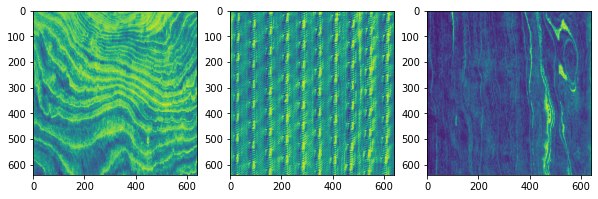

In [ ]:
# Finding and displaying the datapoint/image closest to the mean for each of the classes
im_c1 = np.reshape(centers[0], (640,640))
im_c2 = np.reshape(centers[1], (640,640))
im_c3 = np.reshape(centers[2], (640,640))

map_1 = list(map(lambda x : np.linalg.norm(x - centers[0]), original_res))
map_2 = list(map(lambda x : np.linalg.norm(x - centers[1]), original_res))
map_3 = list(map(lambda x : np.linalg.norm(x - centers[2]), original_res))

plt.figure(figsize = (10,6))
plt.subplot(1,3,1)
plt.imshow(original[np.argmin(map_3)])
plt.subplot(1,3,2)
plt.imshow(original[np.argmin(map_2)])
plt.subplot(1,3,3)
plt.imshow(original[np.argmin(map_1)])

# Working with Broadatz labelled dataset



*   Initially we had an unlabelled dataset of Broadatz texture features
*   We have labelled them in order to get a labelled dataset.
*   Further compressive classification will be done on this dataset, also the efficiency of the classfication method will be evaluated on this 



In [ ]:
import os
import glob
import numpy as np
import scipy.signal as sig
# import pywt
# from pywt import 
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
path = "/content/drive/Shareddrives/Advanced Image Processing/dataset/Original_Brodatz/labelled"

In [ ]:
# Loading the data, downsampling it by 2 for computational purposes into a dictionary with three different labels
data = {}
for i in range(len(os.listdir(path))):
  print(" Collecting images for : ", os.path.join(path,os.listdir(path)[i]) + '/*')
  files = glob.glob(os.path.join(path,os.listdir(path)[i]) + '/*')
  arr = [];
  for j in range(len(files)):
    im = Image.open(files[j])
    # To iterate through the entire gif
    try:
        while 1:
            im.seek(im.tell()+1)
            # do something to im
    except EOFError:
        pass # end of sequence

    widths = np.arange(1,639)

    num_im = np.asarray(im, dtype='int64')
    arr.append(num_im[0::2,0::2])
  data[os.listdir(path)[i]] = arr
    

## a) Sensing Matrix : Bernoulli 

### Getting Compressive Measurements

In [ ]:
from scipy.fft import dct, idct

def dct2(a):
    return dct(dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho')

def idct2(a):
    return idct(idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def get_compressive_measurements(data, sensing_matrix, show_random_samples = False):
  # Obtaining the sensed output
  m = np.shape(sensing_matrix)[0]
  coded_data = {}
  for i in range(len(data.keys())):
    keys = list(data.keys())
    images = data[keys[i]]
    coded_arr = []
    for image in images:
      coded_image = np.matmul(sensing_matrix,np.reshape(dct2(image), (image.size, 1)))
      coded_arr.append(coded_image)
    coded_data[list(data.keys())[i]] = coded_arr

  # Displaying some 5 random images
  if show_random_samples == True:
    for i in range(5):
      idx = np.random.randint(0,3)
      class_im = coded_data[list(coded_data.keys())[idx]]
      idx2 = np.random.randint(0,len(class_im))
      coded_image = class_im[idx2]
      original_image = data[list(coded_data.keys())[idx]][idx2]
      plt.subplot(1,2,1)
      plt.imshow(original_image, cmap='gray')
      plt.title("Original Image")
      plt.subplot(1,2,2)
      plt.imshow(np.reshape(coded_image,(int(np.sqrt(m)),int(np.sqrt(m)))), cmap='gray')
      plt.title("Sensed Image")
      plt.show()

  # generating a random dataset using the orignal data and labels
  labels = []
  c_data = []
  o_data = []
  for i in range(112):
    idx = np.random.randint(0,3)
    class_im = coded_data[list(coded_data.keys())[idx]]
    class_org = data[list(data.keys())[idx]]
    # labels.append(list(coded_data.keys())[idx])
    labels.append(idx)
    idx2 = np.random.randint(0,len(class_im))
    coded_image = class_im[idx2]
    c_data.append(coded_image)
    o_data.append(class_org[idx2])


  return c_data, labels, o_data

def elements_per_class(y_pred_coded, y_pred_original):
  coded  = [0,0,0]
  original = [0 ,0, 0]

  for i in range(len(y_pred_coded)):
    coded[y_pred_coded[i]] += 1
    original[y_pred_original[i]] += 1

  return coded, original

In [ ]:
sensing_matrix = np.random.binomial(n= 1, p = 0.5, size = (256, 320*320))
sensing_matrix = np.where(sensing_matrix == 0, -1/np.sqrt(256), 1/np.sqrt(256))

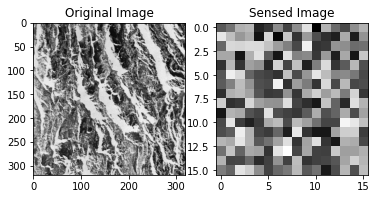

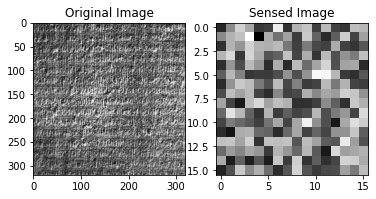

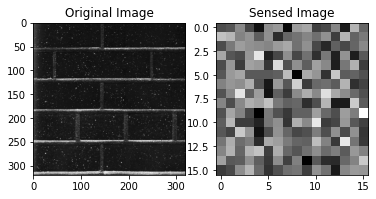

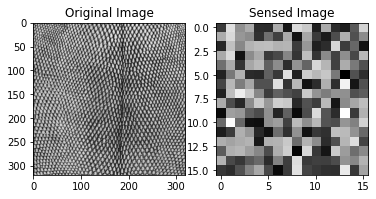

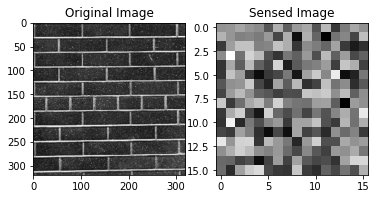

In [ ]:
c_data, labels, o_data = get_compressive_measurements(data, sensing_matrix, True)

In [ ]:
cx_train,cy_train = c_data[0:56],labels[0:56]
cx_test,cy_test = c_data[56:],labels[56:]
ox_train, oy_train = o_data[0:56],labels[0:56]
ox_test, oy_test = o_data[56:], labels[56:]

### SVM Classification 

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classifier_coded = svm.SVC()
classifier_coded.fit(np.reshape(cx_train,(56,256)),cy_train)

classifier_data = svm.SVC()
classifier_data.fit(np.reshape(ox_train,(56,320*320)),oy_train)

y_pred_coded = classifier_coded.predict(np.reshape(cx_test, (56, 256)))
y_pred_original = classifier_data.predict(np.reshape(ox_test, (56, 320*320)))

print("Classification Accuracy on sensed data for m = 256: ",accuracy_score(cy_test, y_pred_coded)) # With size 640*640 = 0.303
print("Classification Accuracy on actual data: ",accuracy_score(oy_test, y_pred_original)) # With size 640*640 = 0.4285

coded_elements, original_elements = elements_per_class(y_pred_coded, y_pred_original)
print("Others , Horizontal , Vertical images in coded : ", coded_elements)
print("Others , Horizontal , Vertical images in original : ", original_elements)

Classification Accuracy on sensed data for m = 256:  0.375
Classification Accuracy on actual data:  0.5714285714285714
Others , Horizontal , Vertical images in coded :  [7, 6, 43]
Others , Horizontal , Vertical images in original :  [14, 15, 27]


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Getting the accuracies for different compression ratios
m = [200, 400, 600, 800, 1000, 1200]
acc_arr = []

sensing_matrix = np.random.binomial(n= 1, p = 0.5, size = (200, 320*320))
sensing_matrix = np.where(sensing_matrix == 0, -1/np.sqrt(200), 1/np.sqrt(200))
_,o_labels,o_data = get_compressive_measurements(data, sensing_matrix)
for i in m:
  sensing_matrix = np.random.binomial(n= 1, p = 0.5, size = (i, 320*320))
  sensing_matrix = np.where(sensing_matrix == 0, -1/np.sqrt(i), 1/np.sqrt(i))

  c_data, c_labels,_ = get_compressive_measurements(data, sensing_matrix)

  cx_train,cy_train = c_data[0:56],c_labels[0:56]
  cx_test,cy_test = c_data[56:],c_labels[56:]
  ox_train, oy_train = o_data[0:56],o_labels[0:56]
  ox_test, oy_test = o_data[56:], o_labels[56:]

  classifier_coded = svm.SVC()
  classifier_coded.fit(np.reshape(cx_train,(56,i)),cy_train)

  classifier_data = svm.SVC()
  classifier_data.fit(np.reshape(ox_train,(56,320*320)),oy_train)

  y_pred_coded = classifier_coded.predict(np.reshape(cx_test, (56, i)))
  y_pred_original = classifier_data.predict(np.reshape(ox_test, (56, 320*320)))

  acc_sensed = accuracy_score(cy_test, y_pred_coded)
  acc_actual = accuracy_score(oy_test, y_pred_original)
  print("Classification Accuracy on sensed data for m = ", i, " : ", acc_sensed)
  print("Classification Accuracy on original data", acc_actual)
  print("-----------------------------------------------------------------------------------------------------")

  acc_arr.append(acc_sensed)


## Since we observe this trend we can say that the sensing matrix obtained from the bernoulli sensing matrix is not distance preserving 

Classification Accuracy on sensed data for m =  200  :  0.48214285714285715
Classification Accuracy on original data 0.48214285714285715
-----------------------------------------------------------------------------------------------------
Classification Accuracy on sensed data for m =  400  :  0.39285714285714285
Classification Accuracy on original data 0.48214285714285715
-----------------------------------------------------------------------------------------------------
Classification Accuracy on sensed data for m =  600  :  0.5
Classification Accuracy on original data 0.48214285714285715
-----------------------------------------------------------------------------------------------------
Classification Accuracy on sensed data for m =  800  :  0.5892857142857143
Classification Accuracy on original data 0.48214285714285715
-----------------------------------------------------------------------------------------------------
Classification Accuracy on sensed data for m =  1000  :  0.46

<function matplotlib.pyplot.show>

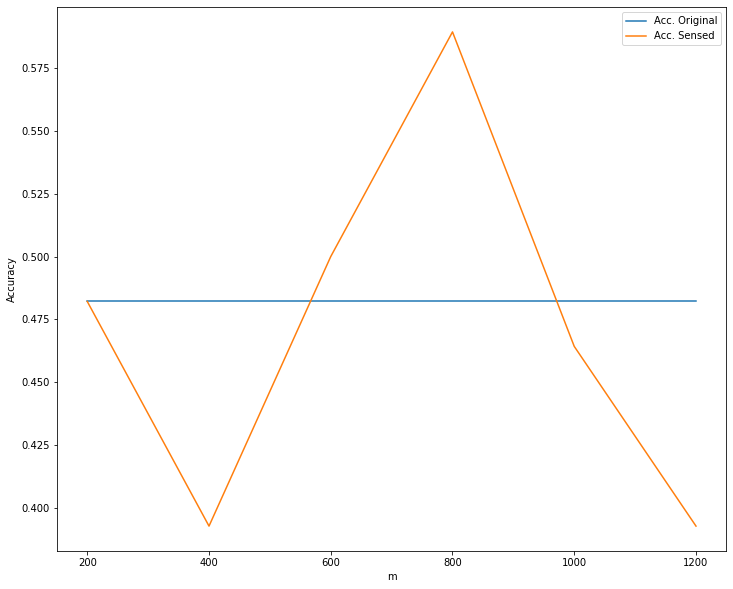

In [ ]:
plt.figure(figsize = (12,10))
plt.plot(m,len(m)*[acc_actual], label = "Acc. Original")
plt.plot(m,acc_arr, label = "Acc. Sensed")
plt.ylabel('Accuracy')
plt.xlabel('m')
plt.legend()
plt.show

As we can see from the above results that a simple bernoulli matrix based coding is not doing a very good job in classification.

###  ANN Classification

In [ ]:
sensing_matrix = np.random.binomial(n= 1, p = 0.5, size = (256, 320*320))
sensing_matrix = np.where(sensing_matrix == 0, -1/np.sqrt(256), 1/np.sqrt(256))

c_data, c_labels,_ = get_compressive_measurements(data, sensing_matrix)

cx_train,cy_train = c_data[0:56],c_labels[0:56]
cx_test,cy_test = c_data[56:],c_labels[56:]
ox_train, oy_train = o_data[0:56],o_labels[0:56]
ox_test, oy_test = o_data[56:], o_labels[56:]

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

#### Classification on Original Data

In [ ]:
ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(128,activation='relu',input_shape = (320*320,)))
# ann_model.add(tf.keras.layers.BatchNormalization())
# ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(256,activation='relu'))
# ann_model.add(tf.keras.layers.BatchNormalization())
# ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(32,activation='relu'))
ann_model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

ann_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13107328  
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 13,148,675
Trainable params: 13,148,675
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 15
history_original = ann_model.fit(
  np.array(np.reshape(ox_train, (56, 320*320))),np.array(oy_train),
  epochs=epochs,
  callbacks = callback
)

Epoch 1/15
2/2 [==============================] - 1s 116ms/step - loss: 3001.6387 - accuracy: 0.3214
Epoch 2/15
2/2 [==============================] - 0s 75ms/step - loss: 3244.1321 - accuracy: 0.3214
Epoch 3/15
2/2 [==============================] - 0s 92ms/step - loss: 1417.7242 - accuracy: 0.1964
Epoch 4/15
2/2 [==============================] - 0s 96ms/step - loss: 571.8492 - accuracy: 0.4107
Epoch 5/15
2/2 [==============================] - 0s 76ms/step - loss: 982.3798 - accuracy: 0.4107
Epoch 6/15
2/2 [==============================] - 0s 76ms/step - loss: 1265.4082 - accuracy: 0.3750
Epoch 7/15
2/2 [==============================] - 0s 100ms/step - loss: 114.5893 - accuracy: 0.6071
Epoch 8/15
2/2 [==============================] - 0s 94ms/step - loss: 108.0733 - accuracy: 0.5357
Epoch 9/15
2/2 [==============================] - 0s 94ms/step - loss: 50.0355 - accuracy: 0.5714
Epoch 10/15
2/2 [==============================] - 0s 74ms/step - loss: 84.3724 - accuracy: 0.6786
Epoch

In [ ]:
ann_model.evaluate(np.array(np.reshape(ox_test, (56, 320*320))), np.array(oy_test))

2/2 [==============================] - 0s 22ms/step - loss: 167.9247 - accuracy: 0.4464


[167.9247283935547, 0.4464285671710968]

In [ ]:
y_pred_original = ann_model.predict(np.array(np.reshape(ox_test, (56, 320*320))))

#### Classification on Sensed Data

In [ ]:
tf.keras.backend.clear_session()

ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(128,activation='relu',input_shape = (256,)))
ann_model.add(tf.keras.layers.Dense(256,activation='relu'))
ann_model.add(tf.keras.layers.Dense(64,activation='relu'))
ann_model.add(tf.keras.layers.Dense(3, activation = 'softmax'))


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

ann_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history_sensed = ann_model.fit(
  np.array(cx_train),np.array(cy_train),
  epochs=epochs,
  callbacks = callback
)

Epoch 1/15
2/2 [==============================] - 0s 10ms/step - loss: 1016.0602 - accuracy: 0.3036
Epoch 2/15
2/2 [==============================] - 0s 6ms/step - loss: 1098.2637 - accuracy: 0.3929
Epoch 3/15
2/2 [==============================] - 0s 11ms/step - loss: 302.0077 - accuracy: 0.5179
Epoch 4/15
2/2 [==============================] - 0s 9ms/step - loss: 363.4348 - accuracy: 0.3929
Epoch 5/15
2/2 [==============================] - 0s 11ms/step - loss: 160.1552 - accuracy: 0.6786
Epoch 6/15
2/2 [==============================] - 0s 10ms/step - loss: 62.1117 - accuracy: 0.7321
Epoch 7/15
2/2 [==============================] - 0s 7ms/step - loss: 71.5687 - accuracy: 0.8036
Epoch 8/15
2/2 [==============================] - 0s 10ms/step - loss: 48.7695 - accuracy: 0.6964
Epoch 9/15
2/2 [==============================] - 0s 10ms/step - loss: 17.3834 - accuracy: 0.8036
Epoch 10/15
2/2 [==============================] - 0s 7ms/step - loss: 23.6294 - accuracy: 0.8571
Epoch 11/15
2/2 

In [ ]:
ann_model.evaluate(np.array(cx_test), np.array(cy_test))

2/2 [==============================] - 0s 7ms/step - loss: 230.5613 - accuracy: 0.6250


[230.561279296875, 0.625]

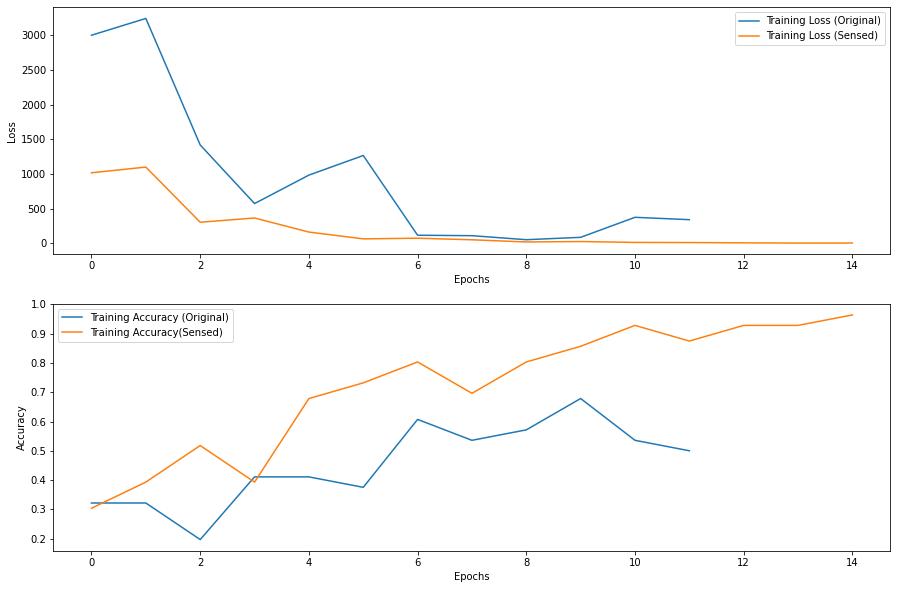

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.plot(history_original.history['loss'], label = "Training Loss (Original)")
plt.plot(history_sensed.history['loss'], label = "Training Loss (Sensed)")
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(2,1,2)
plt.plot(history_original.history['accuracy'], label = "Training Accuracy (Original)")
plt.plot(history_sensed.history['accuracy'], label = "Training Accuracy(Sensed)")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## b) Sensing Matrix : Delsarte-Geothal Frames

In [ ]:
import numpy as np
# Creating a Delsarte Geothal Frame

def DGMatrix(order):
  o = order
  m = 2**o
  n = 2**(2*o)
  arr = np.zeros((m,n))
  for i in range(m):
    form = '{0:0' + str(o) + 'b}'
    t = form.format(i)
    t = np.asarray([int(i) for i in t])
    for j in range(n):
      A = np.random.randint(0,2,size = (o,o))
      P =  np.triu(A) - np.diag(np.diag(A)) + np.transpose(np.triu(A))
      b = np.random.randint(0,2, size = o)
      iota = complex(0,1)
      alpha = (np.linalg.norm(np.reshape(P,P.size), ord = 0) + 2*np.linalg.norm(b, ord = 0))%4
      beta = (np.matmul(np.matmul(t,P),np.transpose(t)) + 2*np.matmul(b,np.transpose(t)))%4
      # beta2 = 2*np.matmul(b,np.transpose(t))%4
      a = (iota**(alpha))*(iota**(beta))
      arr[i,j] = int(a.real)
      if int(a.real) == 0:
        arr[i,j] = 1

  return arr

In [ ]:
## WARNING : Time Intensive Execution
# sensing_matrix = DGMatrix(8)

In [ ]:
# loading the saved DG matrix
sensing_mat = np.load('/content/drive/Shareddrives/Advanced Image Processing/base_matrix.npy')

In [ ]:
sensing_matrix = sensing_mat
for i in range((102400//65536)):
  sensing_matrix = np.hstack((sensing_matrix, np.flip(sensing_matrix, axis = np.random.randint(0,2))))

In [ ]:
sensing_matrix = sensing_matrix[:,:102400]

#### Getting compressive measurements 

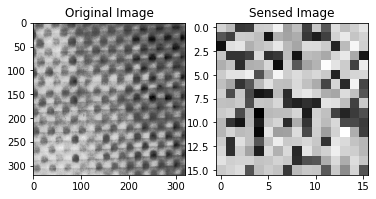

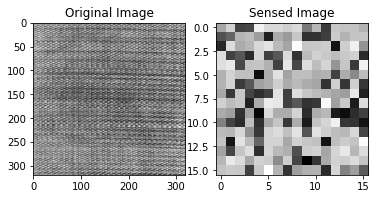

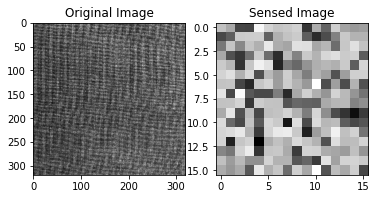

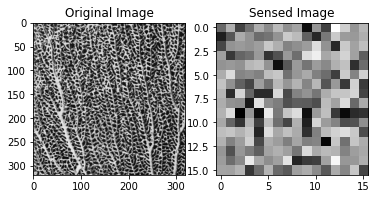

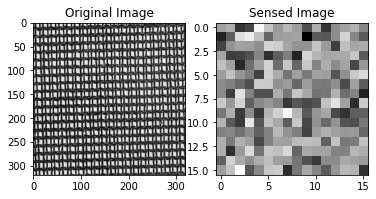

In [ ]:
c_data, labels, o_data = get_compressive_measurements(data, sensing_matrix, True)

In [ ]:
cx_train,cy_train = c_data[0:56],labels[0:56]
cx_test,cy_test = c_data[56:],labels[56:]
ox_train, oy_train = o_data[0:56],labels[0:56]
ox_test, oy_test = o_data[56:], labels[56:]

#### SVM Classification

In [ ]:
from sklearn import svm
classifier_coded = svm.SVC()
classifier_coded.fit(np.reshape(cx_train,(56,256)),cy_train)

SVC()

In [ ]:
classifier_data = svm.SVC()
classifier_data.fit(np.reshape(ox_train,(56,320*320)),oy_train)

SVC()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_coded = classifier_coded.predict(np.reshape(cx_test, (56, 256)))
y_pred_original = classifier_data.predict(np.reshape(ox_test, (56, 320*320)))

print("Accuracy on sensed data: ",accuracy_score(cy_test, y_pred_coded))
print("Accuracy on actual data: ",accuracy_score(oy_test, y_pred_original))

coded_elements, original_elements = elements_per_class(y_pred_coded, y_pred_original)
print("Others , Horizontal , Vertical images in coded : ", coded_elements)
print("Others , Horizontal , Vertical images in original : ", original_elements)

Accuracy on sensed data:  0.48214285714285715
Accuracy on actual data:  0.5357142857142857
Others , Horizontal , Vertical images in coded :  [28, 27, 1]
Others , Horizontal , Vertical images in original :  [37, 16, 3]


###  ANN Classification

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

#### Classification on Original Data 

Done in the Bernoulli matrix section, we'll reuse the results from there

#### Classification on Sensed Data

In [ ]:
tf.keras.backend.clear_session()

ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(128,activation='relu',input_shape = (256,)))
# ann_model.add(tf.keras.layers.BatchNormalization())
# ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(256,activation='relu'))
# ann_model.add(tf.keras.layers.BatchNormalization())
# ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(64,activation='relu'))
ann_model.add(tf.keras.layers.Flatten())
ann_model.add(tf.keras.layers.Dense(3, activation = 'softmax'))


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

ann_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history_sensed = ann_model.fit(
  np.array(c_data),np.array(c_labels),
  validation_split = 0.5,
  epochs=epochs,
  callbacks = callback
)

Epoch 1/15
2/2 [==============================] - 1s 177ms/step - loss: 17058.6523 - accuracy: 0.3571 - val_loss: 20467.1445 - val_accuracy: 0.3214
Epoch 2/15
2/2 [==============================] - 0s 28ms/step - loss: 21024.2070 - accuracy: 0.2679 - val_loss: 9705.3672 - val_accuracy: 0.4107
Epoch 3/15
2/2 [==============================] - 0s 30ms/step - loss: 9045.2031 - accuracy: 0.3571 - val_loss: 6838.2295 - val_accuracy: 0.1964
Epoch 4/15
2/2 [==============================] - 0s 31ms/step - loss: 6452.7705 - accuracy: 0.4286 - val_loss: 8863.3896 - val_accuracy: 0.2857
Epoch 5/15
2/2 [==============================] - 0s 32ms/step - loss: 4918.8477 - accuracy: 0.4286 - val_loss: 4657.5635 - val_accuracy: 0.3036
Epoch 6/15
2/2 [==============================] - 0s 33ms/step - loss: 2165.8618 - accuracy: 0.4464 - val_loss: 3621.6421 - val_accuracy: 0.3929
Epoch 7/15
2/2 [==============================] - 0s 30ms/step - loss: 2689.1953 - accuracy: 0.4464 - val_loss: 2798.0002 - va

In [ ]:
ann_model.evaluate(np.array(cx_test), np.array(cy_test))

2/2 [==============================] - 0s 5ms/step - loss: 2453.3855 - accuracy: 0.3214


[2453.385498046875, 0.3214285671710968]

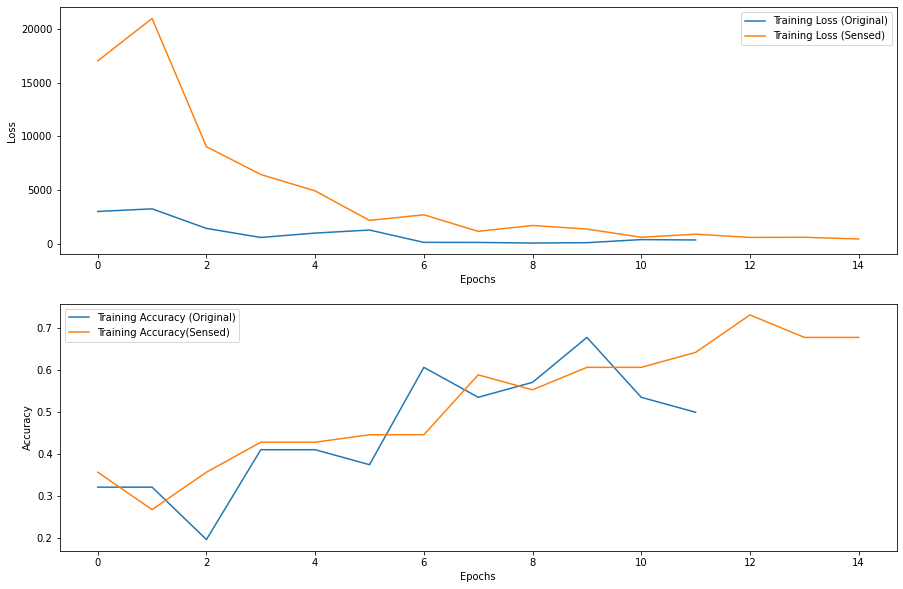

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.plot(history_original.history['loss'], label = "Training Loss (Original)")
plt.plot(history_sensed.history['loss'], label = "Training Loss (Sensed)")
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(2,1,2)
plt.plot(history_original.history['accuracy'], label = "Training Accuracy (Original)")
plt.plot(history_sensed.history['accuracy'], label = "Training Accuracy(Sensed)")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# Working with CIFAR -10

In [ ]:
import os
import glob
import numpy as np
import scipy.signal as sig
import pywt
# from pywt import 
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def get_image(row):
  arr = np.zeros(shape=(32,32,3))
  arr[:,:,0] = np.reshape(row[0:1024], (32,32))
  arr[:,:,1] = np.reshape(row[1024:2048], (32,32))
  arr[:,:,2] = np.reshape(row[2048:3072], (32,32))

  return arr

In [ ]:
dictionary = unpickle("/content/drive/Shareddrives/Advanced Image Processing/dataset/cifar-10-batches-py/data_batch_1")

In [ ]:
data = list(map(lambda x: cv2.cvtColor(np.uint8(get_image(x)), cv2.COLOR_BGR2GRAY), dictionary[b'data']))
labels = dictionary[b'labels']

In [ ]:
def elements_per_class(y_pred_coded, y_pred_original):
  coded  = 10*[0]
  original = 10*[0]

  for i in range(len(y_pred_coded)):
    coded[y_pred_coded[i]] += 1
    original[y_pred_original[i]] += 1

  return coded, original

## a) Sensing Matrix : Bernoulli Random

### Getting Compressive Measurements

In [ ]:
# Getting compressive measurements for the data
sensing_matrix = np.random.binomial(n= 1, p = 0.5, size = (32, 32*32))
sensing_matrix = np.where(sensing_matrix == 0, -1/np.sqrt(32), 1/np.sqrt(32))

In [ ]:
c_data = list(map(lambda x: sensing_matrix @ np.reshape(dct2(x),(32*32,1)), data))

In [ ]:
cx_train,cy_train = c_data[0:9000],labels[0:9000]
cx_test,cy_test = c_data[9000:],labels[9000:]
ox_train, oy_train = data[0:9000],labels[0:9000]
ox_test, oy_test = data[9000:], labels[9000:]

### SVM Classification

In [ ]:
from sklearn import svm
classifier_coded = svm.SVC()
classifier_coded.fit(np.reshape(cx_train,(9000, 32)),cy_train)

SVC()

In [ ]:
classifier_data = svm.SVC()
classifier_data.fit(np.reshape(ox_train,(9000,32*32)),oy_train)

SVC()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_coded = classifier_coded.predict(np.reshape(cx_test, (1000, 32)))
y_pred_original = classifier_data.predict(np.reshape(ox_test, (1000, 32*32)))

print("Accuracy on sensed data: ",accuracy_score(cy_test, y_pred_coded))
print("Accuracy on actual data: ",accuracy_score(oy_test, y_pred_original))

Accuracy on sensed data:  0.304
Accuracy on actual data:  0.389
Others , Horizontal , Vertical images in coded :  [104, 80, 98, 48, 143, 67, 139, 84, 142, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
coded_elements, original_elements = elements_per_class(y_pred_coded, y_pred_original)
print("Number of images classified in classes 1 to 10 in compressed : ", coded_elements)
print("Number of images classified in classes 1 to 10 in original : ", original_elements)

Number of images classified in classes 1 to 10 in compressed :  [104, 80, 98, 48, 143, 67, 139, 84, 142, 95]
Number of images classified in classes 1 to 10 in original :  [88, 84, 115, 69, 113, 85, 140, 76, 134, 96]


###  ANN Classification

In [ ]:
sensing_matrix = np.random.binomial(n= 1, p = 0.5, size = (32, 32*32))
sensing_matrix = np.where(sensing_matrix == 0, -1/np.sqrt(32), 1/np.sqrt(32))

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

#### Classification on Original Data

In [ ]:
ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(64,activation='relu',input_shape = (32*32,)))
ann_model.add(tf.keras.layers.BatchNormalization())
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(64,activation='relu'))
ann_model.add(tf.keras.layers.BatchNormalization())
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(32,activation='relu'))
ann_model.add(tf.keras.layers.Flatten())
ann_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

ann_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65600     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
epochs = 15
history_original = ann_model.fit(
  np.array(np.reshape(ox_train, (9000, 32*32))),np.array(oy_train),
  epochs=epochs,
  callbacks = callback
)

Epoch 1/15
282/282 [==============================] - 2s 4ms/step - loss: 2.2015 - accuracy: 0.2151
Epoch 2/15
282/282 [==============================] - 1s 4ms/step - loss: 2.0268 - accuracy: 0.2694
Epoch 3/15
282/282 [==============================] - 1s 4ms/step - loss: 1.9834 - accuracy: 0.2870
Epoch 4/15
282/282 [==============================] - 1s 4ms/step - loss: 1.9488 - accuracy: 0.3032
Epoch 5/15
282/282 [==============================] - 1s 4ms/step - loss: 1.9408 - accuracy: 0.3026
Epoch 6/15
282/282 [==============================] - 1s 4ms/step - loss: 1.9151 - accuracy: 0.3136
Epoch 7/15
282/282 [==============================] - 1s 4ms/step - loss: 1.9127 - accuracy: 0.3173
Epoch 8/15
282/282 [==============================] - 1s 4ms/step - loss: 1.9086 - accuracy: 0.3112
Epoch 9/15
282/282 [==============================] - 1s 4ms/step - loss: 1.8882 - accuracy: 0.3199
Epoch 10/15
282/282 [==============================] - 1s 4ms/step - loss: 1.8926 - accuracy: 0.3217

In [ ]:
ann_model.evaluate(np.array(np.reshape(ox_test, (1000, 32*32))), np.array(oy_test))

32/32 [==============================] - 0s 2ms/step - loss: 2.1750 - accuracy: 0.3210


[2.1749629974365234, 0.32100000977516174]

In [ ]:
y_pred_original = ann_model.predict(np.array(np.reshape(ox_test, (1000, 32*32))))

#### Classification on Sensed Data

In [ ]:
tf.keras.backend.clear_session()

ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(64,activation='relu',input_shape = (32,)))
ann_model.add(tf.keras.layers.BatchNormalization())
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(64,activation='relu'))
ann_model.add(tf.keras.layers.BatchNormalization())
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(32,activation='relu'))
ann_model.add(tf.keras.layers.Flatten())
ann_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

ann_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history_sensed = ann_model.fit(
  np.array(cx_train),np.array(cy_train),
  epochs=epochs,
  callbacks = callback
)

Epoch 1/15
282/282 [==============================] - 2s 3ms/step - loss: 2.2543 - accuracy: 0.1841
Epoch 2/15
282/282 [==============================] - 1s 3ms/step - loss: 2.0885 - accuracy: 0.2434
Epoch 3/15
282/282 [==============================] - 1s 3ms/step - loss: 2.0361 - accuracy: 0.2662
Epoch 4/15
282/282 [==============================] - 1s 3ms/step - loss: 2.0095 - accuracy: 0.2752
Epoch 5/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9895 - accuracy: 0.2812
Epoch 6/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9723 - accuracy: 0.2934
Epoch 7/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9627 - accuracy: 0.2894
Epoch 8/15
282/282 [==============================] - 1s 4ms/step - loss: 1.9588 - accuracy: 0.2938
Epoch 9/15
282/282 [==============================] - 1s 5ms/step - loss: 1.9432 - accuracy: 0.3013
Epoch 10/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9347 - accuracy: 0.2970

In [ ]:
ann_model.evaluate(np.array(cx_test), np.array(cy_test))

32/32 [==============================] - 0s 2ms/step - loss: 1.8864 - accuracy: 0.3220


[1.8863565921783447, 0.32199999690055847]

In [ ]:
y_pred_coded = ann_model.predict(np.array(cx_test))


coded_elements, original_elements = elements_per_class(list(map(lambda x: np.argmax(x),y_pred_coded)), list(map(lambda x: np.argmax(x),y_pred_original)))
print("Number of images classified in classes 1 to 10 in compressed : ", coded_elements)
print("Number of images classified in classes 1 to 10 in original : ", original_elements)

Number of images classified in classes 1 to 10 in compressed :  [120, 93, 90, 45, 139, 60, 143, 122, 100, 88]
Number of images classified in classes 1 to 10 in original :  [90, 128, 106, 35, 98, 51, 198, 85, 139, 70]


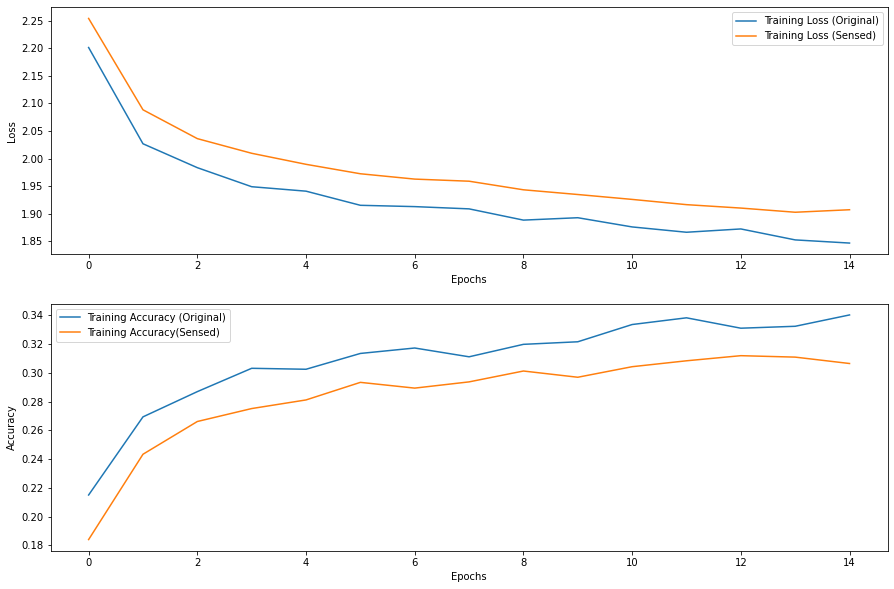

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.plot(history_original.history['loss'], label = "Training Loss (Original)")
plt.plot(history_sensed.history['loss'], label = "Training Loss (Sensed)")
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(2,1,2)
plt.plot(history_original.history['accuracy'], label = "Training Accuracy (Original)")
plt.plot(history_sensed.history['accuracy'], label = "Training Accuracy(Sensed)")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## b) Sensing Matrix : Delsarte - Geothal Frames

In [ ]:
sensing_matrix = DGMatrix(5)

### Getting compressive measurements

In [ ]:
c_data = list(map(lambda x: sensing_matrix @ np.reshape(dct2(x),(32*32,1)), data))

In [ ]:
cx_train,cy_train = c_data[0:9000],labels[0:9000]
cx_test,cy_test = c_data[9000:],labels[9000:]
ox_train, oy_train = data[0:9000],labels[0:9000]
ox_test, oy_test = data[9000:], labels[9000:]

### SVM Classification

In [ ]:
from sklearn import svm
classifier_coded = svm.SVC()
classifier_coded.fit(np.reshape(cx_train,(9000, 32)),cy_train)

SVC()

In [ ]:
classifier_data = svm.SVC()
classifier_data.fit(np.reshape(ox_train,(9000,32*32)),oy_train)

SVC()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_coded = classifier_coded.predict(np.reshape(cx_test, (1000, 32)))
y_pred_original = classifier_data.predict(np.reshape(ox_test, (1000, 32*32)))

print("Accuracy on sensed data: ",accuracy_score(cy_test, y_pred_coded))
print("Accuracy on actual data: ",accuracy_score(oy_test, y_pred_original))

coded_elements, original_elements = elements_per_class(y_pred_coded, y_pred_original)
print("Number of images classified in classes 1 to 10 in compressed : ", coded_elements)
print("Number of images classified in classes 1 to 10 in original : ", original_elements)

Accuracy on sensed data:  0.302
Accuracy on actual data:  0.389
Number of images classified in classes 1 to 10 in compressed :  [109, 66, 106, 45, 121, 65, 146, 75, 159, 108]
Number of images classified in classes 1 to 10 in original :  [88, 84, 115, 69, 113, 85, 140, 76, 134, 96]


###  ANN Classification

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

#### Classification on Original Data 

Done in the Bernoulli matrix section, we'll reuse the results from there

#### Classification on Sensed Data

In [ ]:
tf.keras.backend.clear_session()

ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(64,activation='relu',input_shape = (32,)))
ann_model.add(tf.keras.layers.BatchNormalization())
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(64,activation='relu'))
ann_model.add(tf.keras.layers.BatchNormalization())
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(tf.keras.layers.Dense(32,activation='relu'))
ann_model.add(tf.keras.layers.Flatten())
ann_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

ann_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history_sensed = ann_model.fit(
  np.array(cx_train),np.array(cy_train),
  epochs=epochs,
  callbacks = callback
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


282/282 [==============================] - 2s 3ms/step - loss: 2.2856 - accuracy: 0.1826
Epoch 2/15
282/282 [==============================] - 1s 3ms/step - loss: 2.1148 - accuracy: 0.2386
Epoch 3/15
282/282 [==============================] - 1s 3ms/step - loss: 2.0536 - accuracy: 0.2594
Epoch 4/15
282/282 [==============================] - 1s 3ms/step - loss: 2.0341 - accuracy: 0.2606
Epoch 5/15
282/282 [==============================] - 1s 3ms/step - loss: 2.0115 - accuracy: 0.2797
Epoch 6/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9963 - accuracy: 0.2802
Epoch 7/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9771 - accuracy: 0.2903
Epoch 8/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9669 - accuracy: 0.2892
Epoch 9/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9536 - accuracy: 0.3003
Epoch 10/15
282/282 [==============================] - 1s 3ms/step - loss: 1.9559 - accuracy: 0.2967
Epoch 11/1

In [ ]:
ann_model.evaluate(np.array(np.reshape(cx_test, (1000, 32))), np.array(cy_test))

32/32 [==============================] - 0s 2ms/step - loss: 1.9372 - accuracy: 0.3020


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


[1.9372367858886719, 0.3019999861717224]

In [ ]:
y_pred_coded = ann_model.predict(np.array(cx_test))


coded_elements, original_elements = elements_per_class(list(map(lambda x: np.argmax(x),y_pred_coded)), list(map(lambda x: np.argmax(x),y_pred_original)))
print("Number of images classified in classes 1 to 10 in compressed : ", coded_elements)
print("Number of images classified in classes 1 to 10 in original : ", original_elements)

Number of images classified in classes 1 to 10 in compressed :  [51, 77, 194, 40, 87, 68, 166, 89, 134, 94]
Number of images classified in classes 1 to 10 in original :  [1000, 0, 0, 0, 0, 0, 0, 0, 0, 0]


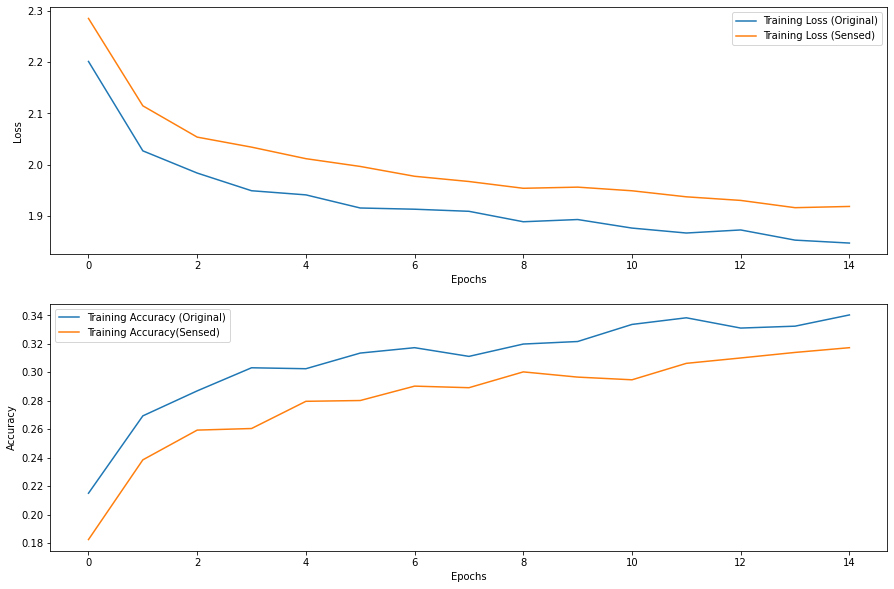

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.plot(history_original.history['loss'], label = "Training Loss (Original)")
plt.plot(history_sensed.history['loss'], label = "Training Loss (Sensed)")
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(2,1,2)
plt.plot(history_original.history['accuracy'], label = "Training Accuracy (Original)")
plt.plot(history_sensed.history['accuracy'], label = "Training Accuracy(Sensed)")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()